拿加權指數資料去訓練AE

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [101]:
# 讀取 CSV 檔案
file_path = "資料前處理/merged_stocks_sorted.csv"
df = pd.read_csv(file_path)
#print(df.head())
# 假設我們要使用數值型的列來做 Autoencoder
#df = df.select_dtypes(include=[np.number]).dropna()

print(df.head())

           日期        成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差  \
0  2010-10-21  20,697,571  2,347,730,094  114.0  114.5  112.5  113.0  -1.00   
1  2010-10-21  40,237,461  2,458,712,121   61.3   61.4   60.8   61.0   0.00   
2  2010-10-21   9,435,865  3,675,093,620  394.0  395.0  386.0  387.0  -5.50   
3  2010-10-22  16,111,879  1,833,691,206  114.5  114.5  113.0  114.0  +1.00   
4  2010-10-22  42,971,490  2,646,457,386   61.7   61.8   61.4   61.8  +0.80   

    成交筆數   SMA_5  ...   SMA_200       EMA_5      EMA_20        RSI       MACD  \
0  9,188  113.60  ...  129.9400  113.598253  115.156901  42.888466  -1.067839   
1  7,376   61.02  ...   60.9100   61.022536   61.126968  49.448148   0.078879   
2  6,346  385.20  ...  496.8100  389.029298  412.053709  32.870088 -18.545872   
3  6,509  113.20  ...  129.7525  113.732169  115.046720  45.751457  -1.032347   
4  9,208   61.00  ...   60.8945   61.281691   61.191067  55.601780   0.124750   

   MACD_signal  MACD_hist  Support_Lev

移除不需要的欄位 只留下 歷史收益率（returns）波動性（volatility）

In [ ]:
df = df[["returns", "volatility"]]

# 查看結果
print(df.head())
print(df.columns)
print(df.info())

In [102]:
df = df.drop(columns=['日期','股票代碼'])

# 查看結果
print(df.head())
print(df.columns)
print(df.info())

         成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差   成交筆數  \
0  20,697,571  2,347,730,094  114.0  114.5  112.5  113.0  -1.00  9,188   
1  40,237,461  2,458,712,121   61.3   61.4   60.8   61.0   0.00  7,376   
2   9,435,865  3,675,093,620  394.0  395.0  386.0  387.0  -5.50  6,346   
3  16,111,879  1,833,691,206  114.5  114.5  113.0  114.0  +1.00  6,509   
4  42,971,490  2,646,457,386   61.7   61.8   61.4   61.8  +0.80  9,208   

    SMA_5   SMA_20  ...   SMA_50   SMA_200       EMA_5      EMA_20        RSI  \
0  113.60  115.825  ...  117.920  129.9400  113.598253  115.156901  42.888466   
1   61.02   61.280  ...   60.514   60.9100   61.022536   61.126968  49.448148   
2  385.20  415.800  ...  442.170  496.8100  389.029298  412.053709  32.870088   
3  113.20  115.650  ...  117.600  129.7525  113.732169  115.046720  45.751457   
4   61.00   61.365  ...   60.546   60.8945   61.281691   61.191067  55.601780   

        MACD  MACD_signal  MACD_hist  Support_Level  Resistance_Leve

In [103]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch

# 讀取數據
print(df.head())
print(df.dtypes)

# 列出所有需要轉換為 float 的欄位
float_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 'SMA_5',
       'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 'RSI',
       'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level']

df[float_columns] = df[float_columns].replace("X0.00", "0")

# 移除 `,` 並轉換為 float
for col in float_columns:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# 確保所有數據都是數值型
print(df.dtypes)
print(df.head())

# 進行標準化處理 (MinMaxScaler)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df.values)

print("標準化後的數據:")
print(data_scaled[:5])

# 轉換為 PyTorch Tensor
data_tensor = torch.tensor(data_scaled, dtype=torch.float32)

# 查看處理後的數據形狀
print("數據張量形狀:", data_tensor.shape)


         成交股數           成交金額    開盤價    最高價    最低價    收盤價   漲跌價差   成交筆數  \
0  20,697,571  2,347,730,094  114.0  114.5  112.5  113.0  -1.00  9,188   
1  40,237,461  2,458,712,121   61.3   61.4   60.8   61.0   0.00  7,376   
2   9,435,865  3,675,093,620  394.0  395.0  386.0  387.0  -5.50  6,346   
3  16,111,879  1,833,691,206  114.5  114.5  113.0  114.0  +1.00  6,509   
4  42,971,490  2,646,457,386   61.7   61.8   61.4   61.8  +0.80  9,208   

    SMA_5   SMA_20  ...   SMA_50   SMA_200       EMA_5      EMA_20        RSI  \
0  113.60  115.825  ...  117.920  129.9400  113.598253  115.156901  42.888466   
1   61.02   61.280  ...   60.514   60.9100   61.022536   61.126968  49.448148   
2  385.20  415.800  ...  442.170  496.8100  389.029298  412.053709  32.870088   
3  113.20  115.650  ...  117.600  129.7525  113.732169  115.046720  45.751457   
4   61.00   61.365  ...   60.546   60.8945   61.281691   61.191067  55.601780   

        MACD  MACD_signal  MACD_hist  Support_Level  Resistance_Leve

In [87]:
print(torch.isnan(data_tensor).sum())  # NaN 個數
print(torch.isinf(data_tensor).sum())  # 無窮大個數

tensor(0)
tensor(0)


In [88]:
nan_rows = torch.any(torch.isnan(data_tensor), dim=1)
print("含 NaN 的行索引:", torch.nonzero(nan_rows))
print("含 NaN 的數據:", data_tensor[nan_rows])


含 NaN 的行索引: tensor([], size=(0, 1), dtype=torch.int64)
含 NaN 的數據: tensor([], size=(0, 21))


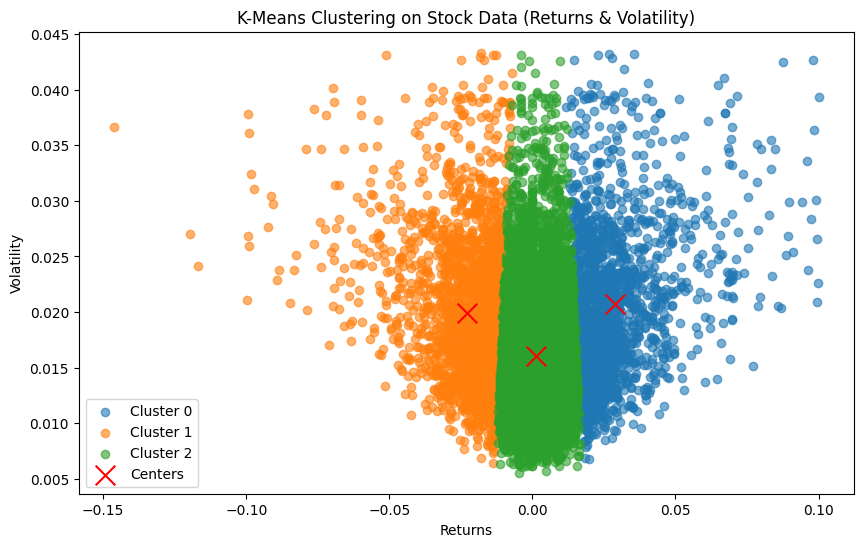

    returns  volatility  cluster
0 -0.008772    0.017411        2
1  0.000000    0.011037        2
2 -0.014013    0.019865        1
3  0.008850    0.017333        2
4  0.013115    0.011250        2


In [25]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 設定要分的群數（可以調整）
num_clusters = 3  

# 執行 K-Means 分群
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df)  # 取得每個數據點的群集標籤

# 可視化結果
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    subset = df[df["cluster"] == cluster]
    plt.scatter(subset["returns"], subset["volatility"], label=f"Cluster {cluster}", alpha=0.6)

# 繪製 K-Means 分群中心點
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='red', marker='x', s=200, label="Centers")

plt.xlabel("Returns")
plt.ylabel("Volatility")
plt.title("K-Means Clustering on Stock Data (Returns & Volatility)")
plt.legend()
plt.show()

# 顯示部分數據
print(df.head())


/tmp/ipykernel_79333/1638578904.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


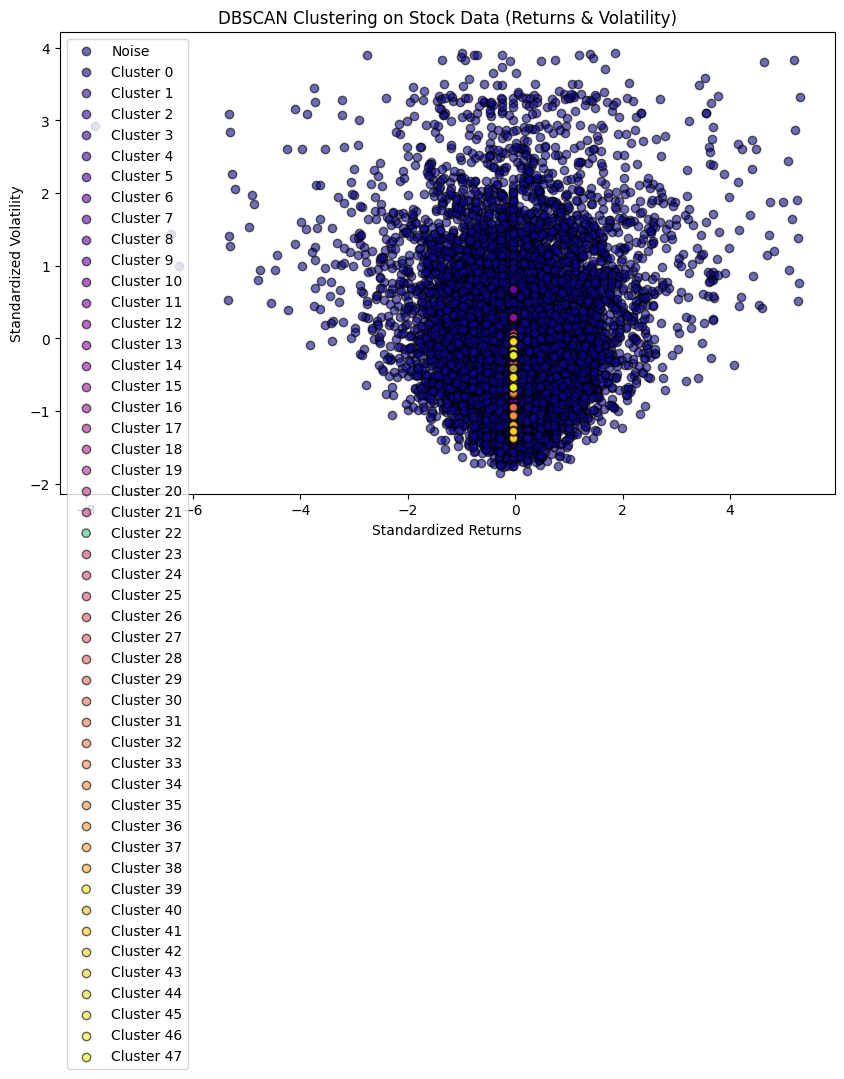

    returns  volatility  cluster
0 -0.008772    0.017411       -1
1  0.000000    0.011037        6
2 -0.014013    0.019865       -1
3  0.008850    0.017333       -1
4  0.013115    0.011250       -1
5  0.000000    0.019864       -1
6  0.039474    0.018585       -1
7  0.003236    0.011220       -1
8  0.020672    0.019401       -1
9 -0.004219    0.014533       -1


In [41]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 標準化數據
scaler = StandardScaler()
df_filtered = df[["returns", "volatility"]].dropna()  # 移除 NaN 值
scaled_data = scaler.fit_transform(df_filtered)  # 標準化數據

# 執行 DBSCAN
dbscan = DBSCAN(eps=0.005, min_samples=5)  # 減小 eps
clusters = dbscan.fit_predict(scaled_data)  # 計算分群

# 將結果加回原始 DataFrame (確保索引對齊)
df.loc[df_filtered.index, "cluster"] = clusters

# 取得唯一群集標籤
unique_clusters = np.unique(clusters)

# 建立顏色對應表
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))  # 生成顏色

plt.figure(figsize=(10, 6))

# 繪製 DBSCAN 群集
for cluster, color in zip(unique_clusters, colors):
    mask = clusters == cluster  # 找到屬於該群的點
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"  # -1 是雜訊
    plt.scatter(
        scaled_data[mask, 0], scaled_data[mask, 1], 
        c=color, label=label, alpha=0.6, edgecolors='k'
    )

# 加上圖例
plt.legend()
plt.xlabel("Standardized Returns")
plt.ylabel("Standardized Volatility")
plt.title("DBSCAN Clustering on Stock Data (Returns & Volatility)")
plt.show()

# 顯示部分數據
print(df.head(10))


Epoch [1/100], Loss: 0.0019
Epoch [2/100], Loss: 0.0003
Epoch [3/100], Loss: 0.0008
Epoch [4/100], Loss: 0.0003
Epoch [5/100], Loss: 0.0004
Epoch [6/100], Loss: 0.0006
Epoch [7/100], Loss: 0.0001
Epoch [8/100], Loss: 0.0016
Epoch [9/100], Loss: 0.0005
Epoch [10/100], Loss: 0.0004
Epoch [11/100], Loss: 0.0009
Epoch [12/100], Loss: 0.0001
Epoch [13/100], Loss: 0.0005
Epoch [14/100], Loss: 0.0005
Epoch [15/100], Loss: 0.0002
Epoch [16/100], Loss: 0.0006
Epoch [17/100], Loss: 0.0005
Epoch [18/100], Loss: 0.0001
Epoch [19/100], Loss: 0.0004
Epoch [20/100], Loss: 0.0003
Epoch [21/100], Loss: 0.0000
Epoch [22/100], Loss: 0.0001
Epoch [23/100], Loss: 0.0001
Epoch [24/100], Loss: 0.0004
Epoch [25/100], Loss: 0.0000
Epoch [26/100], Loss: 0.0001
Epoch [27/100], Loss: 0.0003
Epoch [28/100], Loss: 0.0002
Epoch [29/100], Loss: 0.0003
Epoch [30/100], Loss: 0.0004
Epoch [31/100], Loss: 0.0002
Epoch [32/100], Loss: 0.0003
Epoch [33/100], Loss: 0.0005
Epoch [34/100], Loss: 0.0005
Epoch [35/100], Loss: 0

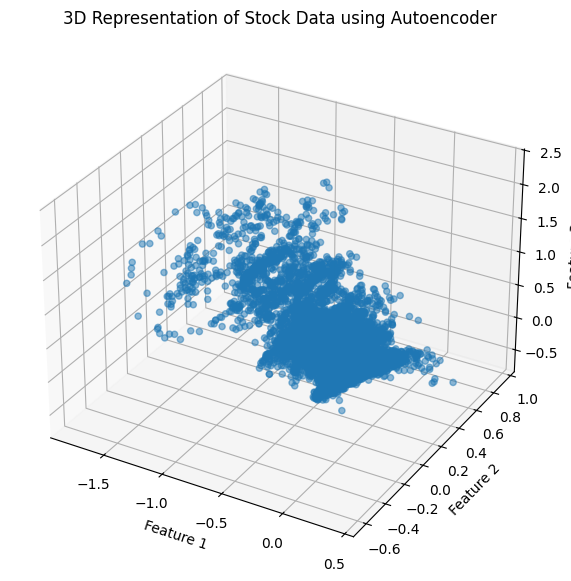

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.mplot3d import Axes3D

# 設定 batch size
batch_size = 32
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 定義 Autoencoder
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # 壓縮到 3 維
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)  # 重建原始輸入
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

# 初始化模型
input_dim = data_tensor.shape[1]  # 原始特徵數
model = AutoEncoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    for batch in dataloader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_reconstructed, _ = model(x)
        loss = criterion(x_reconstructed, x)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

torch.save(model.state_dict(), "autoencoder_model.pth")
print("模型已儲存至 autoencoder_model.pth")

# 提取 3D 特徵
model.eval()
encoded_data = model.encoder(data_tensor.to(device)).detach().cpu().numpy()

# 可視化 3D 壓縮後的數據
encoded_df = pd.DataFrame(encoded_data, columns=["Feature1", "Feature2", "Feature3"])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_df["Feature1"], encoded_df["Feature2"], encoded_df["Feature3"], alpha=0.5)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("3D Representation of Stock Data using Autoencoder")
plt.show()


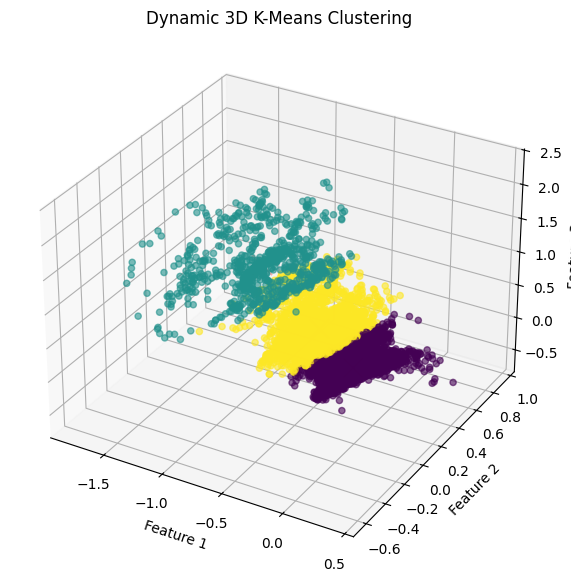

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from sklearn.cluster import KMeans

# 設定 K-Means 參數
num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(encoded_data)  
centers = kmeans.cluster_centers_  

# 建立 3D 圖表
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 繪製分群點
scatter = ax.scatter(
    encoded_data[:, 0], encoded_data[:, 1], encoded_data[:, 2], 
    c=clusters, cmap='viridis', alpha=0.6
)

# 繪製 K-Means 群中心
ax.scatter(
    centers[:, 0], centers[:, 1], centers[:, 2], 
    c='red', marker='x', s=200, label="Cluster Centers"
)

# 設定軸標籤
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("Dynamic 3D K-Means Clustering")

# 旋轉動畫函數
def rotate(angle):
    ax.view_init(elev=20, azim=angle)

# 動畫
animation = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 2), interval=50)

# 顯示動畫
plt.show()

# 如果想存成 GIF 或 MP4，可以啟用這行：
#animation.save("3D_kmeans_rotation.gif", writer="pillow", fps=20)


In [114]:
import plotly.express as px
import pandas as pd

# 轉換數據為 DataFrame
df = pd.DataFrame(encoded_data, columns=["Feature1", "Feature2", "Feature3"])
df["Cluster"] = clusters  # 加入分群標籤

# 建立 3D 互動圖
fig = px.scatter_3d(df, x="Feature1", y="Feature2", z="Feature3", color=df["Cluster"].astype(str))

# 顯示 3D 互動視覺化
fig.show()


/home/r11011101/anaconda3/envs/myenv/lib/python3.10/site-packages/matplotlib/animation.py:872: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



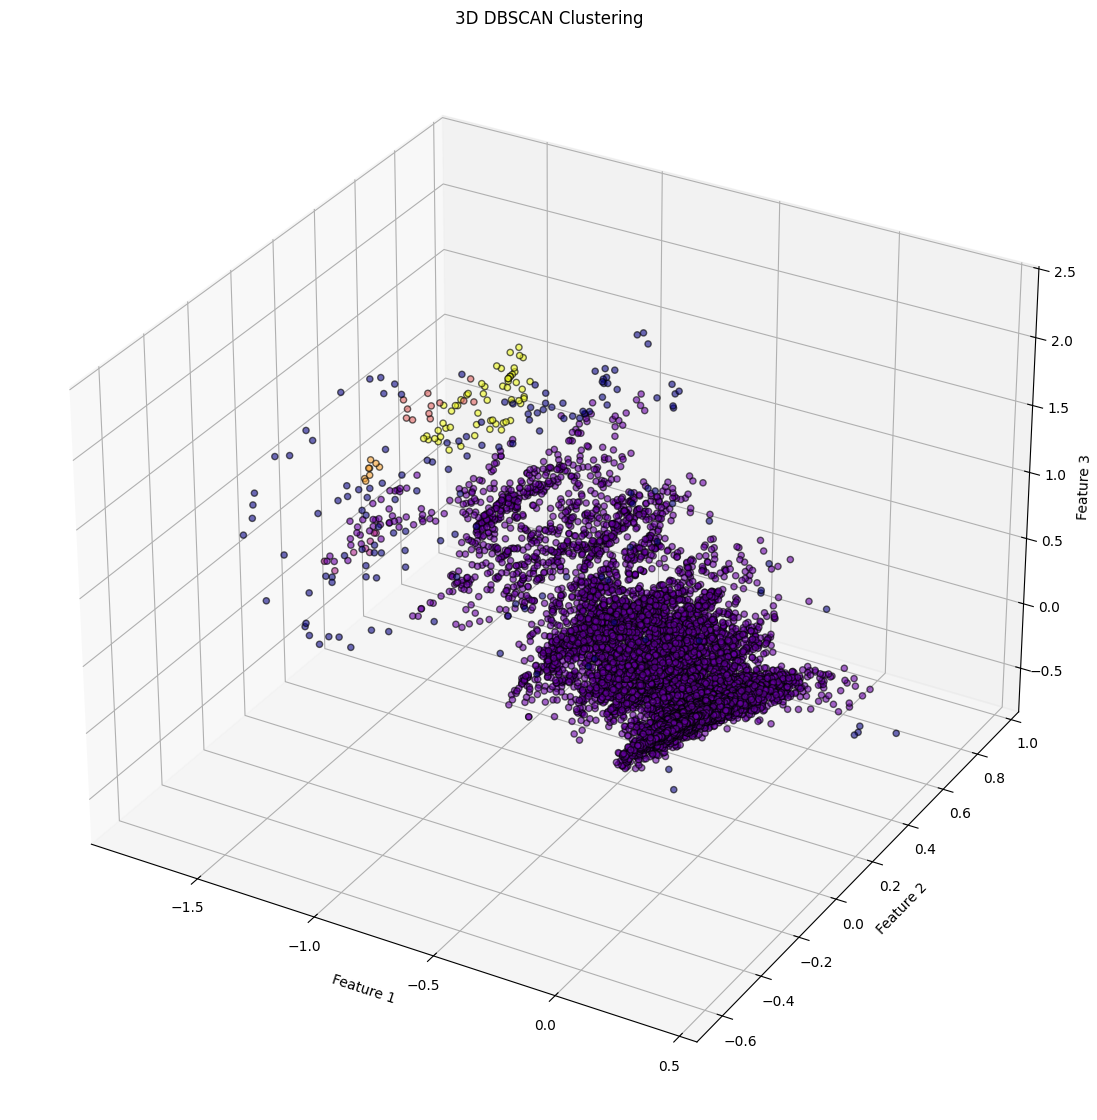

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from sklearn.cluster import DBSCAN

# 執行 DBSCAN 分群
dbscan = DBSCAN(eps=0.15, min_samples=8)
clusters = dbscan.fit_predict(encoded_data)  # 每個點的群集標籤

# 取得唯一的群集標籤
unique_clusters = np.unique(clusters)

# 建立顏色對應表
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))

# 建立 3D 圖表
fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111, projection='3d')

# 繪製每個群集
for cluster, color in zip(unique_clusters, colors):
    mask = clusters == cluster  # 找出屬於該群集的點
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"  # -1 是雜訊
    ax.scatter(
        encoded_data[mask, 0], encoded_data[mask, 1], encoded_data[mask, 2], 
        c=[color], label=label, alpha=0.6, edgecolors='k'
    )

# 設定軸標籤
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
ax.set_title("3D DBSCAN Clustering")

# 旋轉動畫函數
def rotate(angle):
    ax.view_init(elev=20, azim=angle)

# 動畫
animation = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 2), interval=50)

# 顯示動畫
plt.show()

# 若要存成 GIF / MP4，啟用這行：
# animation.save("3D_DBSCAN_rotation.gif", writer="pillow", fps=20)


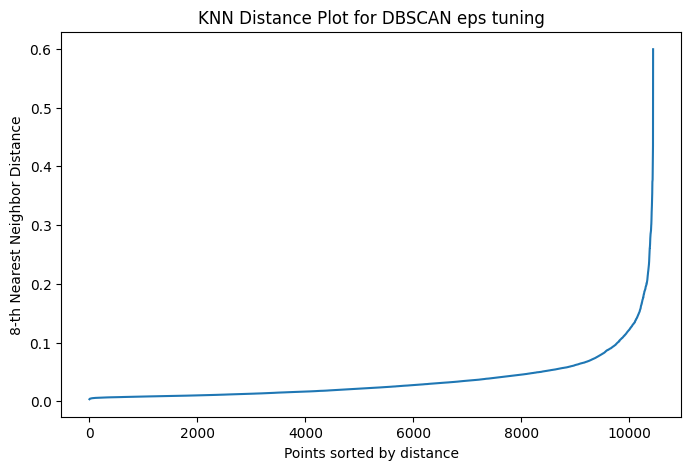

In [119]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# 計算 KNN 距離 (k = min_samples)
k = 8  # 與 DBSCAN 的 min_samples 保持一致
nbrs = NearestNeighbors(n_neighbors=k).fit(encoded_data)
distances, indices = nbrs.kneighbors(encoded_data)

# 取出每個點的 k-距離 (第 k 近的鄰居)
k_distances = np.sort(distances[:, -1])  # 取最後一列 (第 k 近的距離)

# 繪製 KNN 距離圖
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("KNN Distance Plot for DBSCAN eps tuning")
plt.show()


In [120]:
from sklearn.cluster import DBSCAN

for eps in [0.1, 0.12, 0.15]:
    dbscan = DBSCAN(eps=eps, min_samples=8)
    clusters = dbscan.fit_predict(encoded_data)
    print(f"eps={eps}，分群數量: {len(set(clusters)) - (1 if -1 in clusters else 0)}，雜訊數量: {(clusters == -1).sum()}")


eps=0.1，分群數量: 15，雜訊數量: 407
eps=0.12，分群數量: 11，雜訊數量: 281
eps=0.15，分群數量: 5，雜訊數量: 145


In [123]:
import plotly.express as px
import pandas as pd

# 轉換數據為 DataFrame
df = pd.DataFrame(encoded_data, columns=["Feature1", "Feature2", "Feature3"])
df["Cluster"] = clusters  # 加入分群標籤

# 建立 3D 互動圖
fig = px.scatter_3d(df, x="Feature1", y="Feature2", z="Feature3", color=df["Cluster"].astype(str))

# 顯示 3D 互動視覺化
fig.show()


二維數據Kmeans

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 進行 K-Means 分群
num_clusters = 3  # 你可以嘗試不同數值
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(encoded_data)  # 取得每個點的群集標籤

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label="Centers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-Means Clustering on 2D Autoencoder Features")
plt.legend()
plt.show()


二維數據DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# 執行 DBSCAN 分群
dbscan = DBSCAN(eps=0.05, min_samples=8)
clusters = dbscan.fit_predict(encoded_data)  # 每個點的群集標籤

# 取得唯一的群集標籤
unique_clusters = np.unique(clusters)

# 建立顏色對應表
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))  # 使用 plasma colormap

plt.figure(figsize=(16, 12))

# 繪製每個群集
for cluster, color in zip(unique_clusters, colors):
    mask = clusters == cluster  # 取得當前群集的索引
    label = f"Cluster {cluster}" if cluster != -1 else "Noise"  # -1 代表雜訊
    plt.scatter(encoded_data[mask, 0], encoded_data[mask, 1], c=[color], label=label, alpha=0.6, edgecolors='k')

# 加上圖例
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering with Legend")
plt.show()


二維數據尋找dbsacn最佳參數

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

#  建議測試範圍（避免圖太多）
eps_values = np.arange(0.025, 0.11, 0.005)  # 0.005 ~ 0.05, 每次增加 0.005（10 種 eps）
min_samples_values = [3, 5, 10]  # 測試 3 種 min_samples

#  動態調整圖的排列方式
n_rows = len(eps_values)
n_cols = len(min_samples_values)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 6))
fig.suptitle("DBSCAN Clustering with Different Parameters", fontsize=16)

# 迴圈測試不同的 eps 和 min_samples
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        ax = axes[i, j] if n_rows > 1 else axes[j]  # 適應 1 行時的情況
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(encoded_data)  # 執行分群

        unique_clusters = np.unique(clusters)  # 取得不同的群集標籤
        colors = plt.cm.plasma(np.linspace(0, 1, len(unique_clusters)))  # 生成顏色

        # 繪製當前參數的分群結果
        for cluster, color in zip(unique_clusters, colors):
            mask = clusters == cluster  # 找到屬於該群的點
            label = f"Cluster {cluster}" if cluster != -1 else "Noise"  # -1 是雜訊
            ax.scatter(encoded_data[mask, 0], encoded_data[mask, 1], c=[color], label=label, alpha=0.6, edgecolors='k')

        ax.set_title(f"eps={eps:.3f}, min_samples={min_samples}")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")

# 調整間距，確保標題不會擠在一起
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


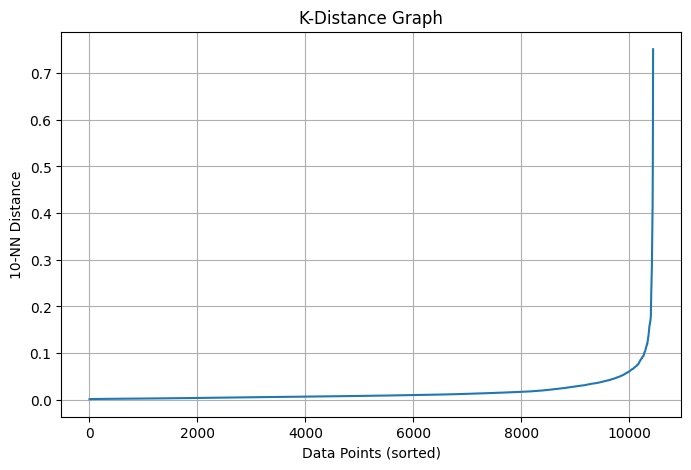

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 計算每個點到其 min_samples 個最近鄰點的距離
min_samples = 10  # 你可以嘗試不同數值
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(encoded_data)
distances, _ = nbrs.kneighbors(encoded_data)

# 取出每個點到 min_samples 鄰居的距離，並排序
k_distances = np.sort(distances[:, -1])

# 繪製 K-Distance Graph
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Data Points (sorted)")
plt.ylabel(f"{min_samples}-NN Distance")
plt.title("K-Distance Graph")
plt.grid()
plt.show()


In [96]:
for eps in [0.02, 0.03, 0.05, 0.07, 0.1, 0.15]:
    dbscan = DBSCAN(eps=eps, min_samples=10)  
    labels = dbscan.fit_predict(encoded_data)
    
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  
    num_noise = list(labels).count(-1)  
    print(f"eps={eps}: 群集數量={num_clusters}, 噪聲點數量={num_noise}")


eps=0.02: 群集數量=14, 噪聲點數量=1666
eps=0.03: 群集數量=19, 噪聲點數量=986
eps=0.05: 群集數量=11, 噪聲點數量=375
eps=0.07: 群集數量=7, 噪聲點數量=201
eps=0.1: 群集數量=2, 噪聲點數量=86
eps=0.15: 群集數量=1, 噪聲點數量=43


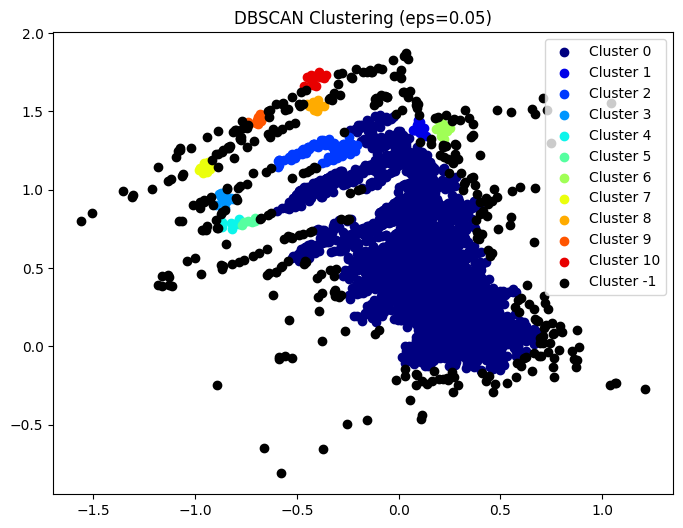

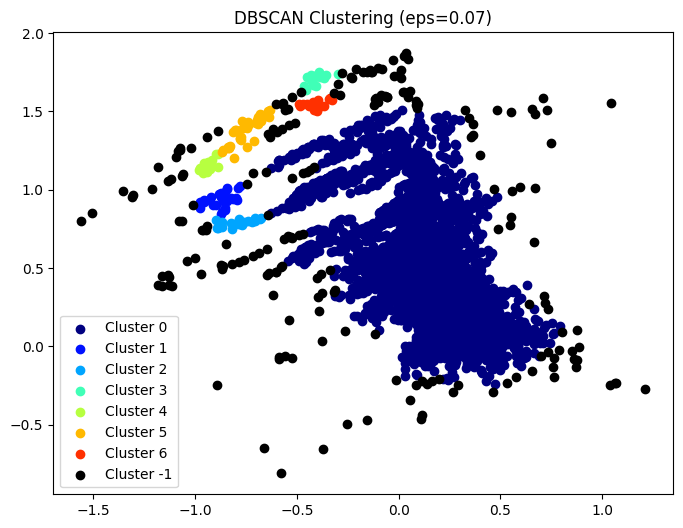

In [99]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dbscan_clusters(data, labels, eps):
    unique_labels = set(labels)
    colors = [plt.cm.jet(each) for each in np.linspace(0, 1, len(unique_labels))]

    plt.figure(figsize=(8, 6))
    for label, color in zip(unique_labels, colors):
        if label == -1:
            color = (0, 0, 0, 1)  # 噪聲點設為黑色
        
        mask = (labels == label)
        plt.scatter(data[mask, 0], data[mask, 1], color=color, label=f'Cluster {label}')

    plt.title(f'DBSCAN Clustering (eps={eps})')
    plt.legend()
    plt.show()

# 嘗試視覺化 eps=0.5 和 eps=0.6
for eps in [0.05, 0.07]:
    dbscan = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan.fit_predict(encoded_data)
    plot_dbscan_clusters(encoded_data, labels, eps)
